<a href="https://colab.research.google.com/github/smomtahe/Project_BreastCancer_Advanced_DeepLearnig/blob/main/Deep_Fusion_and_Residual_Attention_for_NIR_Imaging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Conv2D, Input, Reshape
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import os

# Load images from the zip file
with zipfile.ZipFile('/content/images.zip', 'r') as zip_ref:
    zip_ref.extractall('') # /content/images

Streaming output truncated to the last 5000 lines.
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.1660 - mae: 0.3647 - val_loss: 0.1265 - val_mae: 0.3131
Epoch 3/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.1096 - mae: 0.2548 - val_loss: 0.0917 - val_mae: 0.2196
Epoch 4/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0911 - mae: 0.2327 - val_loss: 0.0925 - val_mae: 0.2142
Epoch 5/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0883 - mae: 0.2145 - val_loss: 0.0878 - val_mae: 0.2117
Epoch 6/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0833 - mae: 0.2039 - val_loss: 0.0870 - val_mae: 0.2145
Epoch 7/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0825 - mae: 0.2069 - val_loss: 0.0902 - val_mae: 0.2041
Epoch 8/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0787 - mae: 0.1918 - val_loss: 0.0875 - val_mae: 0.2095
Epoch 9/2500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0802 - mae: 0.2030 - val_loss: 0.0878 - val_mae: 0.2030
Epoch 10/2500
8/8 ━━━━━━━━

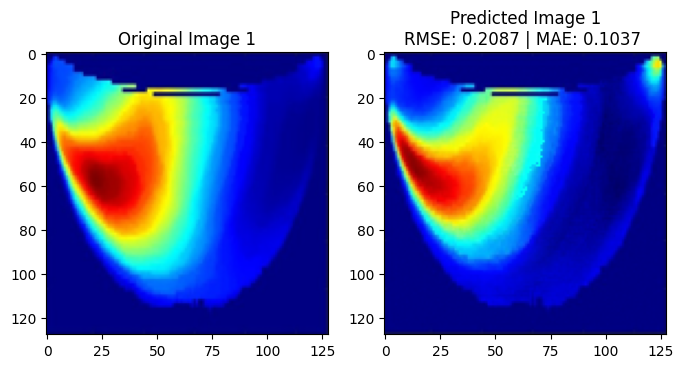

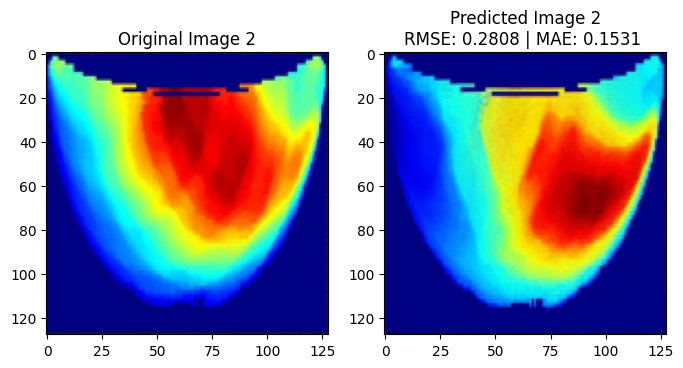

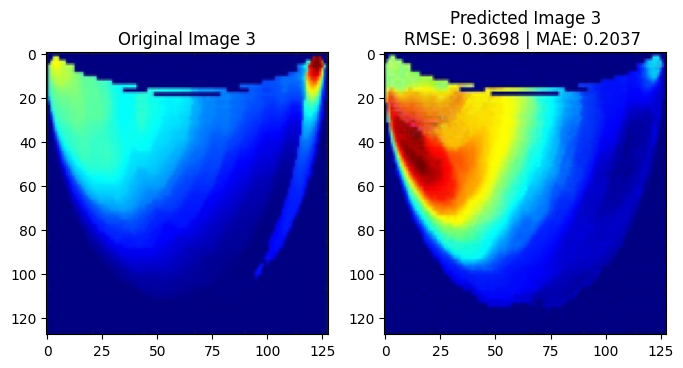

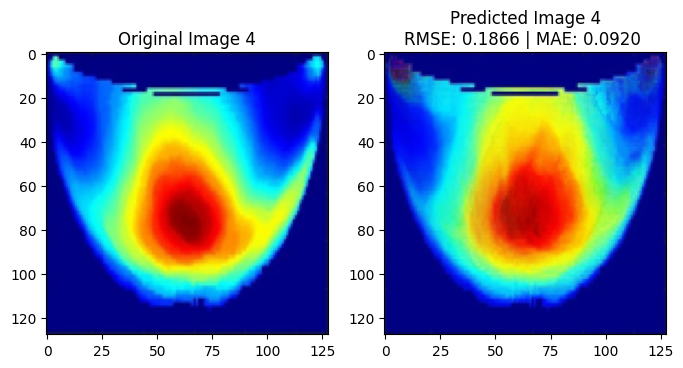

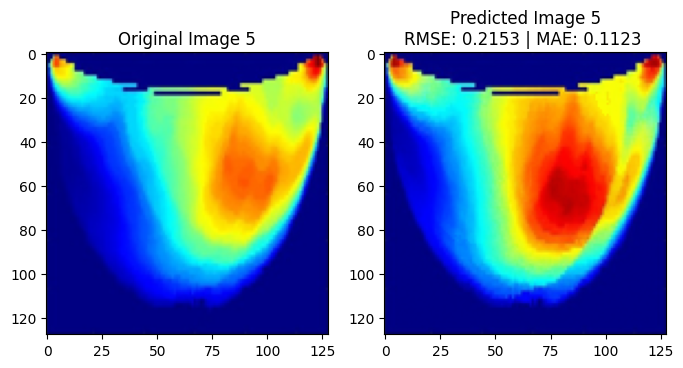

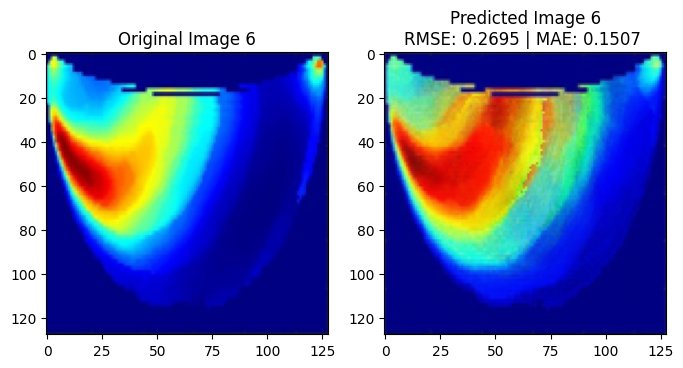

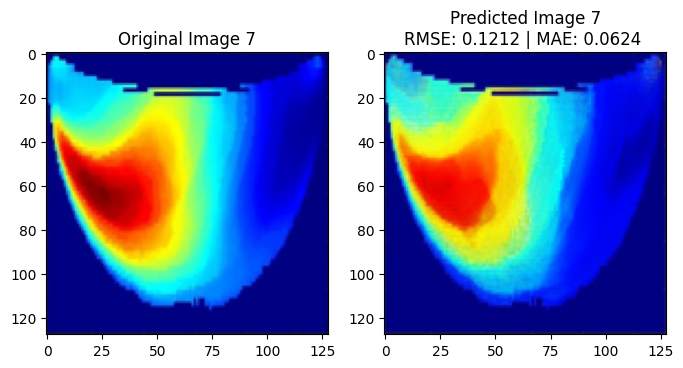

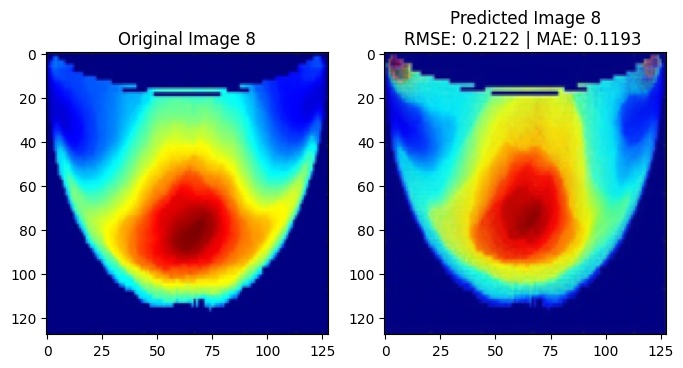

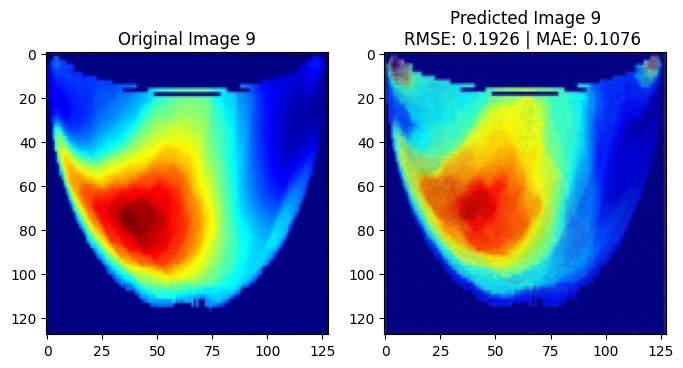

Model architecture and weights saved to model.keras
Model weights saved to model_weights.weights.h5


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Input, Conv1D, Conv2D, MaxPooling2D, Reshape, Concatenate, Multiply, GlobalAveragePooling2D, Add
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import Image
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load dataset
data_df = pd.read_csv('/content/DatasetNewPhantom.csv')
X_led1_reflectance = data_df.iloc[:, 3:131].values
X_led2_reflectance = data_df.iloc[:, 131:259].values
image_paths = data_df.iloc[:, 1].values

# Scale reflectance values
scaler = MinMaxScaler(feature_range=(0, 1))
X_led1_reflectance = scaler.fit_transform(X_led1_reflectance)
X_led2_reflectance = scaler.fit_transform(X_led2_reflectance)

# Function to load and preprocess images
def load_image(img_path):
    img = Image.open(img_path).resize((128, 128))
    return img_to_array(img) / 255.0

# Load all images as targets
Y_images = np.array([load_image(os.path.join('/content/images', img_path)) for img_path in image_paths])

# Reshape data for CNN input
X_led1_reflectance_cnn = X_led1_reflectance.reshape(-1, 128, 1)
X_led2_reflectance_cnn = X_led2_reflectance.reshape(-1, 128, 1)

# Train-test split
X_led1_train, X_led1_test, X_led2_train, X_led2_test, Y_train, Y_test = train_test_split(
    X_led1_reflectance_cnn, X_led2_reflectance_cnn, Y_images, test_size=0.2, random_state=42)

# Squeeze-and-Excite block
def squeeze_excite_block(input_tensor, ratio=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    return Multiply()([input_tensor, se])

# Residual Attention Block
def residual_attention_block(x, filters, kernel_size=3):
    residual = x
    x = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = Conv2D(filters, kernel_size, padding='same', activation='relu')(x)
    x = squeeze_excite_block(x)
    return Add()([x, residual])

# Define CNN model with attention mechanism
def build_attention_cnn(input_shape):
    # Input for LED1 reflectance
    input_led1 = Input(shape=input_shape)
    x1 = Conv1D(32, kernel_size=3, activation='relu')(input_led1)
    x1 = Flatten()(x1)
    x1 = Dense(128 * 128 * 3, activation='relu')(x1)
    x1 = Reshape((128, 128, 3))(x1)

    # Input for LED2 reflectance
    input_led2 = Input(shape=input_shape)
    x2 = Conv1D(32, kernel_size=3, activation='relu')(input_led2)
    x2 = Flatten()(x2)
    x2 = Dense(128 * 128 * 3, activation='relu')(x2)
    x2 = Reshape((128, 128, 3))(x2)

    # Concatenate the two inputs
    x = Concatenate()([x1, x2])

    # Residual Attention Blocks
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    for _ in range(4):
        x = residual_attention_block(x, 32)

    # Apply Conv2D layers after attention blocks
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten()(x)

    # Fusion Layer with gating mechanism
    x = Dense(128, activation='relu')(x)
    gate = Dense(128, activation='sigmoid')(x)
    x = Multiply()([x, gate])  # Gating mechanism

    # Output Layer for image reconstruction
    x = Dense(128 * 128 * 3, activation='sigmoid')(x)
    outputs = Reshape((128, 128, 3))(x)

    model = Model([input_led1, input_led2], outputs)
    return model

# Build and compile the model
image_cnn = build_attention_cnn((128, 1))
image_cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss='mean_squared_error',
                  metrics=['mae'])

# Train the model
history = image_cnn.fit([X_led1_train, X_led2_train], Y_train,
                        epochs=2500,
                        batch_size=4,
                        validation_split=0.1)

# Predict images for the test set
predicted_images = image_cnn.predict([X_led1_test, X_led2_test])

# Calculate RMSE, MAE, and PSNR for each predicted image
rmse_values = []
mae_values = []
psnr_values = []
for i in range(len(Y_test)):
    rmse = np.sqrt(mean_squared_error(Y_test[i].flatten(), predicted_images[i].flatten()))
    mae = mean_absolute_error(Y_test[i].flatten(), predicted_images[i].flatten())
    psnr = tf.image.psnr(Y_test[i], predicted_images[i], max_val=1.0).numpy().mean()
    rmse_values.append(rmse)
    mae_values.append(mae)
    psnr_values.append(psnr)

# Average RMSE, MAE across all test images
average_rmse = np.mean(rmse_values)
average_mae = np.mean(mae_values)
average_psnr = np.mean(psnr_values)
print(f"Average RMSE across all images: {average_rmse}")
print(f"Average MAE across all images: {average_mae}")

# Display the predicted images alongside the original ones with metrics
num_images = min(len(predicted_images), len(Y_test))
for i in range(num_images):
    plt.figure(figsize=(8, 4))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(Y_test[i])
    plt.title(f"Original Image {i+1}")

    # Predicted Image
    plt.subplot(1, 2, 2)
    plt.imshow(predicted_images[i])
    plt.title(f"Predicted Image {i+1}\nRMSE: {rmse_values[i]:.4f} | MAE: {mae_values[i]:.4f} ")

    plt.show()

# Save the entire model in the recommended .keras format
image_cnn.save('model.keras')
print("Model architecture and weights saved to model.keras")

# Save only the model weights with the correct .weights.h5 extension
image_cnn.save_weights('model_weights.weights.h5')
print("Model weights saved to model_weights.weights.h5")
